<a href="https://colab.research.google.com/github/saidElhachemy/Age-rating/blob/main/Age_rating_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des librairies necessaires

In [ ]:
import io
import pandas as pd
import os
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
import math
import glob
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.utils import to_categorical
from keras.models import load_model
from keras.models import Model, Sequential
from keras.layers import TimeDistributed
from keras.layers import Conv2D,Conv3D
from keras.layers import MaxPooling2D
from keras.layers import Flatten,Reshape
from keras.layers import BatchNormalization

Using TensorFlow backend.


# $1^{ére}$ Etape : Utilisation d'un model de prédiction d'age <br>
**Pour calculer le facteur de vieillissement**

**Les weights de model que nous avons sont définit pour une architecture spécifique, donc il faut la redéfinir avant de faire load de ces weights :**

In [ ]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

**les 7 dernier layers n'entre pas dans l'architecture, donc on les omet**

In [ ]:
for layer in model.layers[:-7]:
    layer.trainable = False
 
base_model_output = Sequential()
base_model_output = Convolution2D(101, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)
 
age_model = Model(inputs=model.input, outputs=base_model_output)

**load les weights**

In [ ]:
age_model.load_weights('age_model_weights.h5')
# summarize model.
age_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_27_input (Inp (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_27 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_28 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_29 (ZeroPaddi (None, 114, 114, 64)      0         
__________

# tester le model

**les image sur lesquelles on va tester le model doivent etre de shape (224, 224, 3) !!**

(224, 224, 3)


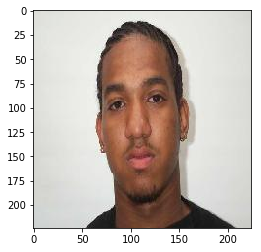

In [ ]:
img = plt.imread('18.jpeg')
print(img.shape)
plt.imshow(img)

In [ ]:
imga = np.asarray(img)

**le model prend comme entrée un array des images, donc l'entrée doit etre de shape (nbr d'image,224,224,3), dans ce cas nbr d'image est 1, car on test sur une seule image**

In [ ]:
im = imga.reshape((1,224,224,3))

In [ ]:
predictions = age_model.predict(im)

**la sortie est un array de 101 element, car ce model est testé sur des images de personnes agées jusqu'à 100, ici, on fait la somme sur les probas données par ces prédictions**

In [ ]:
output_indexes = np.array([i for i in range(0, 101)])
apparent_predictions = np.sum(predictions * output_indexes, axis = 1)

**Voila !**

In [ ]:
print(int(*apparent_predictions))

20


# Passons au étape suivante

## Préparation des données

In [ ]:
def extraire_age(title):
    return int(title.split("_")[0])

In [ ]:
images = [f for f in listdir("images")] #lire les nom des images utilisées
for x in images:
    #resizing images
    x = x.lower()
    img = Image.open("images/"+x)
    if(len(np.asarray(img).shape)==3 and extract_age(x)>=18): #prendre les image en couleurs de personnes agées de plus que 18
        imag = img.resize((224,224))
        img = np.asarray(imag).reshape((1,224,224,3))
        predictions = age_model.predict(img) #predir l'age
        output_indexes = np.array([i for i in range(0, 101)])
        apparent_predictions = np.sum(predictions * output_indexes, axis = 1)
        pred = int(apparent_predictions[0])
        imag.save('dataset/'+str(extract_age(x))+"_"+str(pred)+"_"+str(i)+".jpeg")

In [ ]:
#extraction de dataSet
targets = []
features = []
for file in liste_images:
    img = Image.open(file)
    features.append(np.array(img))
    age_reel = file.split('_')[0]
    age_pred = file.split('_')[1]
    target = age_pred / (age_pred + age_reel) # le facteur de vieillissement
    targets.append(target)

features = np.array(features)
targets = np.array(targets)

print("features shape", features.shape)
print("Targets shape", targets.shape)

features shape (4450, 224, 224, 3)
Targets shape (4450,)


**Diviser la dataset pour apprentissage et test**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(features, targets, test_size=0.3, random_state=101)

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_valid.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_valid.shape)

X_train.shape (3115, 224, 224, 3)
X_valid.shape (1335, 224, 224, 3)
y_train.shape (3115,)
y_valid.shape (1335,)


**L'architecture choisi pour l'entrainement** <br>
*une version partielle de VGG16*

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(128, (3,3), activation='relu',padding='same'))
model.add(Conv2D(128, (3,3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(256, (3,3), activation='relu',padding='same'))
model.add(Conv2D(256, (3,3), activation='relu',padding='same'))
model.add(Conv2D(256, (3,3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=3,padding='same'))
model.add(Conv2D(256, (3,3), activation='relu',padding='same'))
model.add(Conv2D(256, (3,3), activation='relu',padding='same'))
model.add(Conv2D(256, (3,3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=3,padding='same'))
model.add(Reshape((int(model.output.shape[1]),int(model.output.shape[2]*model.output.shape[3]))))
model.add(LSTM(256,activation="relu",return_sequences=False))

model.add(Dropout(0.2))
model.add(Dense(1))
#datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)

model.summary()

#model.compile(optimizer='adam', loss='mse')
model.compile(optimizer=SGD(lr=0.001), loss='mean_squared_logarithmic_error')
#model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_37 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_487 (Conv2D)          (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_488 (Conv2D)          (None, 222, 222, 64)      36928     
_________________________________________________________________
max_pooling2d_218 (MaxPoolin (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_489 (Conv2D)          (None, 74, 74, 128)       73856     
_________________________________________________________________
conv2d_490 (Conv2D)          (None, 74, 74, 128)       147584    
_________________________________________________________________
max_pooling2d_219 (MaxPoolin (None, 24, 24, 128)       0         
__________

**Phase d'entrainement**<br>
*Nous avons utilisé 0.2 de la dataset d'entrainement pour la validation*

In [ ]:
history = model.fit(X_train, y_train, epochs=20,validation_split=0.2,batch_size=32, verbose=1)
#model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),steps_per_epoch=len(X_train) / 32, epochs=20)

Train on 2492 samples, validate on 623 samples
Epoch 1/20
2492/2492 [==============================] - 25s 10ms/step - loss: 0.1032 - val_loss: 0.0822
Epoch 2/20
2492/2492 [==============================] - 19s 8ms/step - loss: 0.0650 - val_loss: 0.0522
Epoch 3/20
2492/2492 [==============================] - 19s 8ms/step - loss: 0.0407 - val_loss: 0.0326
Epoch 4/20
2492/2492 [==============================] - 19s 8ms/step - loss: 0.0248 - val_loss: 0.0197
Epoch 5/20
2492/2492 [==============================] - 19s 8ms/step - loss: 0.0146 - val_loss: 0.0115
Epoch 6/20
2492/2492 [==============================] - 19s 8ms/step - loss: 0.0084 - val_loss: 0.0067
Epoch 7/20
2492/2492 [==============================] - 19s 8ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 8/20
2492/2492 [==============================] - 19s 8ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 9/20
2492/2492 [==============================] - 19s 8ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 10/20
2492/2492 [==

*Une fonction qui dessine le learning curve*

In [ ]:
def Xplot(hist):
    f, axarr = plt.subplots(1,1, figsize=(20, 5))

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    axarr.set_title('Model loss')
    axarr.set_ylabel('Loss')
    axarr.set_xlabel('Epoch')
    axarr.legend(['Train', 'val'], loc='upper left')
    plt.show()

**Les deux courbe converge vers le minimum d'erreur en 10 epoch**<br>
*Le modéle peut bien généraliser*

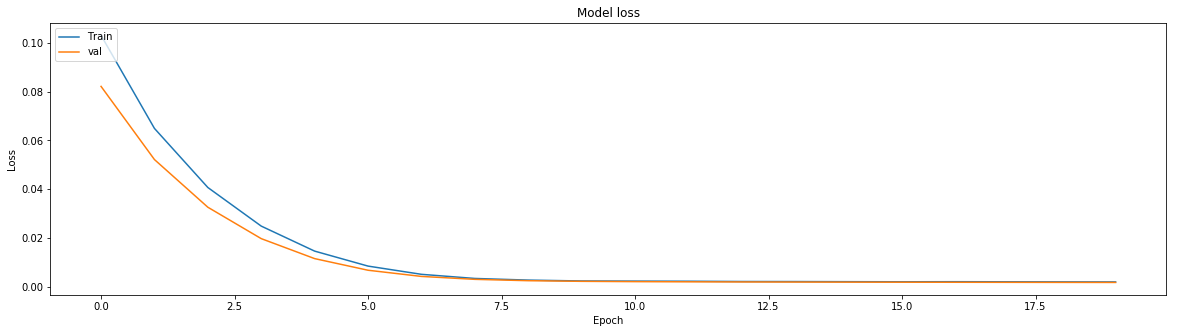

In [ ]:
Xplot(history)

**Evaluation de modéle en utilisant le MSE, car c'est un problème de régression**<br>
*le mse est faible ce qui montre que le modéle marche bien*

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_valid)
mean_squared_error(y_valid, y_pred)

0.0032797976094213867

**Le teste de modéle**<br>
*Ici nous avons testé sur une images pour avoir le facteur de vieillissement*

In [ ]:
model.predict(img.reshape(1,224,224,3))

array([0.57142857])

In [ ]:
model.predict(X_valid[0].reshape(1,224,224,3))

array([[0.50567865]], dtype=float32)